In [2]:
import numpy as np
import scipy
import copy
import time
from scipy.stats import poisson
from scipy.stats import norm
import brewer2mpl
import numpy as np
import itertools
import matplotlib.pyplot as plt
import matplotlib.patches as patches

from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"
import sys
import scipy.io
import pandas as pd
from scipy.stats import uniform
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor, ExtraTreesRegressor

from sklearn import linear_model
import matplotlib.pyplot as plt

from utilities import *
from partition_class import *
from matplotlib.colors import Normalize
from matplotlib import cm
from mpl_toolkits.axes_grid1 import make_axes_locatable

Toy example 1

In [3]:
box1=np.array([[0,5], [0,5]])
box2=np.array([[5,10],[5,10]])
omega1=200
omega2=100 
np.random.seed(0)
x1=np.random.uniform(0,10,1000)
x2=np.random.uniform(0,10,1000)
sigma=1
y=np.zeros(1000)
for i in range (1000):
    if  x1[i]<5 and x2[i]<5:
        y[i]=np.random.normal(omega1,sigma)
    elif x1[i]>5 and x2[i]>5:
        y[i]=np.random.normal(omega2,sigma)
    else:
        y[i]=np.random.normal(0,sigma)

#generate samples from the true parameters

x=np.array([x1,x2])
x=np.transpose(x)
x.reshape(1000,2)



array([[5.48813504, 5.92880271],
       [7.15189366, 0.10063696],
       [6.02763376, 4.75826196],
       ...,
       [9.38412022, 4.80107807],
       [2.28646551, 6.43864037],
       [6.77141144, 5.01773131]])

In [12]:
dif=max(y)-min(y)
std=dif/2
print(dif,std)

206.04595283336297 103.02297641668149


Text(0.5, 1.0, 'Samples with parameter')

Text(0.5, 0, 'x1')

Text(0, 0.5, 'x2')

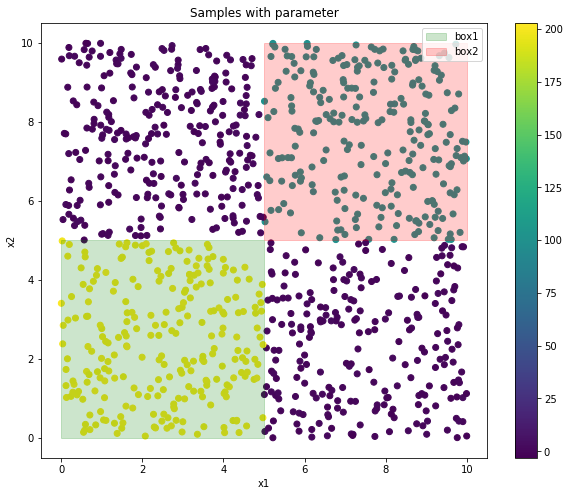

In [5]:
fig = plt.figure(figsize=(10,8))
ax = fig.add_subplot(1, 1, 1)
rect1 = plt.Rectangle((0, 0), 5, 5, color='green', alpha=0.2,label='box1')
rect2 = plt.Rectangle((5, 5), 5, 5, color='red', alpha=0.2,label='box2')
ax.add_patch(rect1,)
ax.add_patch(rect2)
ax.set_title('Samples with parameter')
im=ax.scatter(x1,x2 , c=y, marker='o')
ax.set_xlabel('x1')
ax.set_ylabel('x2')
ax.legend(loc='best')


fig.colorbar(im, ax=ax)



parameters

In [6]:
# parameters
dataNum = 100
dimNum = 2
lambdas = 10
taus = 0.04


In [13]:
def test_run():
    dataNum = 100 # the actual training dataNum is 1000
    dimNum = 2
    lambdas = 0.4
    # taus_seq = np.array([0.2, 0.5, 0.7, 1.0, 1.5, 2.0, 2.5, 3.0, 4.0, 5.0])
    # taus_seq = np.array([6.0, 7.0, 8.0, 9.0, 10.0])
    taus = 0.5
    testt = np.random.rand()

    # for taus in taus_seq:
    run_mainfunction(dataNum, dimNum, lambdas, taus, testt)

def run_mainfunction(dataNum, dimNum, lambdas, taus, testt):

    xdata=x 
    ydata =y
    train_test_ratio = 0.5 # the ratio of test data
    xdata_train, ydata_train, xdata_test, ydata_test, ydata_train_mean, dd, hyper_sigma_1, hyper_sigma_2, variance_hat = pre_process_data(xdata, ydata, train_test_ratio)

    dimLength = np.ones(dimNum)*10 # the length vector for all the dimensions


    IterationTime = 2000

    RBP = PartitionPatch(dimLength, dataNum, taus, lambdas, np.mean(ydata_train), variance_hat)
    # print('Expected number of boxes is: '+str(RBP.patchNum))

    predicted_value_train_seq = np.zeros((IterationTime, len(ydata_train)))
    predicted_value_test_seq = np.zeros((IterationTime, len(ydata_test)))
    train_RMAE_seq = np.zeros(IterationTime)
    test_RMAE_seq = np.zeros(IterationTime)
    Numbox = np.zeros(IterationTime)
    lambda_seq = np.zeros(IterationTime)

    for tt in range(IterationTime):
        RBP.Metropolis_Hastings_omegas(xdata_train, ydata_train)
        RBP.Metropolis_Hastings_A(xdata_train, ydata_train)
        RBP.hyperparameter_update(xdata_train, ydata_train, hyper_sigma_1, hyper_sigma_2)
        RBP.sample_patchNum(xdata_train, ydata_train)
        RBP.hyper_sample()

        tvals_train = RBP.total_judge(xdata_train)
        predicted_value_train_seq[tt] = np.dot(tvals_train, RBP.omegas)
        tvals_test = RBP.total_judge(xdata_test)
        predicted_value_test_seq[tt] = np.dot(tvals_test, RBP.omegas)

        train_RMAE_seq[tt] = np.mean(abs(predicted_value_train_seq[tt]-ydata_train)*dd)
        test_RMAE_seq[tt] = np.mean(abs(predicted_value_test_seq[tt]-ydata_test)*dd)
        Numbox[tt] = RBP.patchNum
        lambda_seq[tt] = RBP.lambdas
        if np.mod(tt+1, 10)==0:
            print('============= Iteration '+str(tt+1) + ' finished. =============')
            print('Number of boxes is: '+ str(RBP.patchNum))
            print('assigned value' + str(RBP.omegas*dif+std))
            print('patch parameter' + str(RBP.patchPara))

    final_RMAE_train = np.mean(((np.mean(predicted_value_train_seq[int(IterationTime/2):, :], axis=0).reshape((-1))-ydata_train.reshape((-1)))*dd)**2)
    final_RMAE_test = np.mean(((np.mean(predicted_value_test_seq[int(IterationTime/2):, :], axis=0).reshape((-1))-ydata_test.reshape((-1)))*dd)**2)



if __name__ == '__main__':
    test_run()

dd: 205.50814698695334, ydata_mean:100.17502274828719
============= Iteration 10 finished. =============
Number of boxes is: 9
assigned value[ 75.71966449  73.49962153  15.12825211  83.04966002  28.56463319
 212.86147401 112.64384371 114.41825371 109.36847203]
patch parameter[[[ 0.         10.        ]
  [ 0.         10.        ]]

 [[ 0.          0.09442924]
  [ 2.06564057  0.05442479]]

 [[ 9.81097144  0.18902856]
  [ 0.          0.02745722]]

 [[ 7.904071    0.25728858]
  [ 2.24828304  0.36233439]]

 [[ 7.620945    0.08311245]
  [ 0.          0.3001435 ]]

 [[ 2.14108082  0.5738909 ]
  [ 0.39259311  2.86242367]]

 [[ 9.7440961   0.23100406]
  [ 0.          0.05159338]]

 [[ 1.02139289  0.33495356]
  [ 2.0124003   0.4657182 ]]

 [[ 0.19600617  1.40018432]
  [ 3.18477089  0.07611117]]]
============= Iteration 20 finished. =============
Number of boxes is: 7
assigned value[ 77.21049584 105.02907392 -37.52831278 107.08640297 152.28128567
 186.24681147 128.42769309]
patch parameter[[[ 0.

In [ ]:
print(y)